### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 6
### Due: Saturday, Mar 14th at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [1]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

#### Part 1

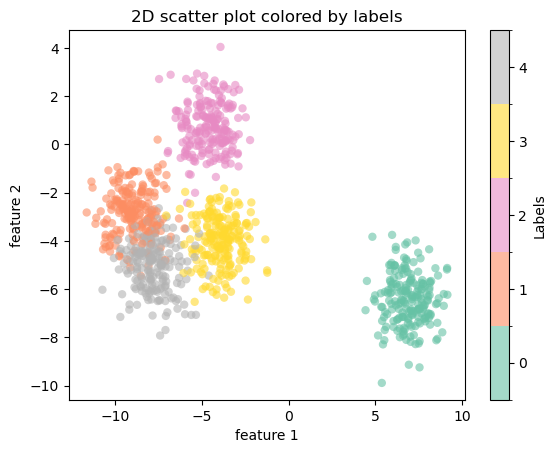

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

data = np.load('../../../homeworks/hw_data/hw6_data_1.npy')

# To plot a 2-D scatter plot of the data colored by the labels, I do the below hotch-potch to put a colorbar 
# with discrete cmap indicating the corresponding color of the label.

# Choosing the cmap
cmap = mpl.cm.Set2

# Scatter plot command with BoundaryNorm norm method to put the colorbar ticks at the center of each discrete color
plt.scatter(data[:,0], data[:,1], c=data[:,2], cmap=cmap, alpha=0.6,
            norm=mpl.colors.BoundaryNorm(np.arange(-0.5,5.5,1), cmap.N), edgecolor='None')

# Colorbar with ticks according to labels
plt.colorbar(ticks=[0, 1, 2, 3, 4], label='Labels', spacing='proportional')

plt.title("2D scatter plot colored by labels")
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()

#### Part 2

Optimal Bandwidth:  0.4724137931034482


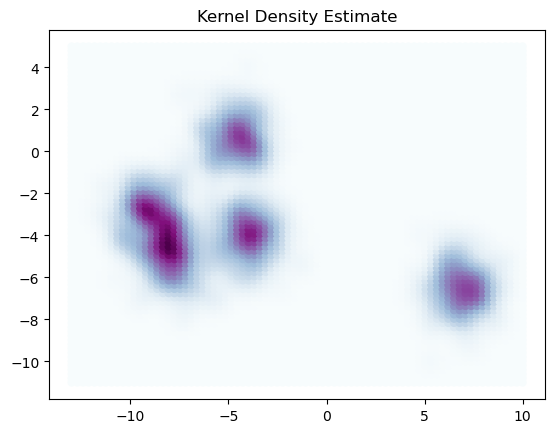

In [3]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# Finding optimal bandwidth
bwrange = np.linspace(0.1, 1.0, 30)
K = 5
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K)
grid.fit(data[:, 0:2])
h_opt = grid.best_params_['bandwidth']
print("Optimal Bandwidth: ", h_opt)


# Plotting 2D kernel density estimate
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(data[:, 0:2])

u = np.linspace(-13,10,80)
v = np.linspace(-11,5,80)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid))

plt.title("Kernel Density Estimate")
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens,
            cmap='BuPu', edgecolor="None")
#plt.colorbar()
plt.show()

#### Part 3

k = 100 or around makes the plot similar to KDE distribution.


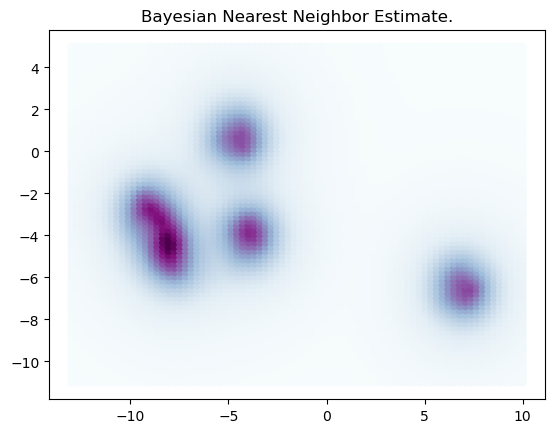

In [4]:
from astroML.density_estimation import KNeighborsDensity


k = 100
N = 1000

nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(data[:, 0:2])
dens_nbrs = nbrs.eval(Xgrid) / N

print("k = 100 or around makes the plot similar to KDE distribution.")

plt.title("Bayesian Nearest Neighbor Estimate.")
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_nbrs,
            cmap='BuPu', edgecolor="None")
#plt.colorbar()
plt.show()

#### Part 4

The optimal number of component according to BIC:  4


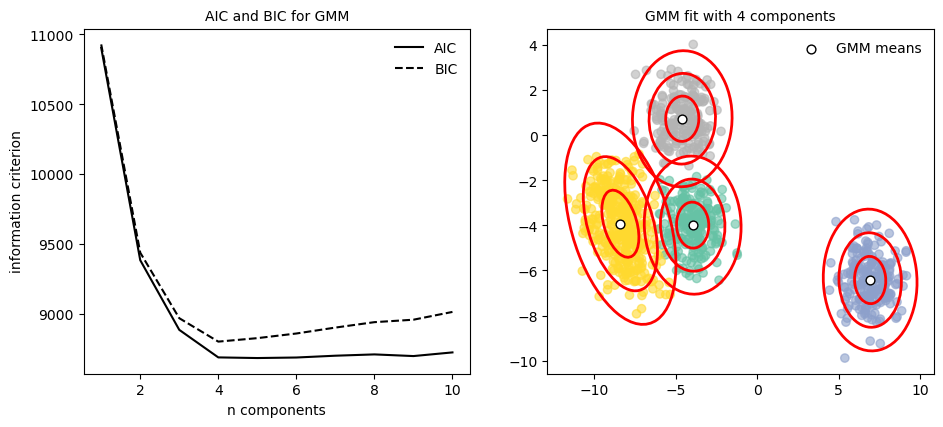

In [6]:
from sklearn.mixture import GaussianMixture


# GMM fit and computing AIC and BIC
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(data[:, 0:2])

AIC = [m.aic(data[:, 0:2]) for m in models]
BIC = [m.bic(data[:, 0:2]) for m in models]

opt_comp_bic = np.argmin(BIC)+1
print("The optimal number of component according to BIC: ", opt_comp_bic)



# Plotting
fig = plt.figure(3, figsize=(10, 5))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.2)


ax1 = fig.add_subplot(121)
ax1.set_title("AIC and BIC for GMM", fontsize=10)
ax1.plot(N, AIC, '-k', label='AIC')
ax1.plot(N, BIC, '--k', label='BIC')
ax1.set_xlabel('n components')
ax1.set_ylabel('information criterion')
ax1.legend(frameon=False)



ax2 = fig.add_subplot(122)
ax2.set_title(f"GMM fit with %s components" %opt_comp_bic, fontsize=10)
ax2.scatter(data[:,0], data[:,1], c=models[opt_comp_bic-1].predict(data[:,0:2]), 
            cmap=cmap, alpha=0.6)

for i in range(opt_comp_bic):
    draw_ellipse(models[opt_comp_bic-1].means_[i], models[opt_comp_bic-1].covariances_[i], ax=ax2, 
                 edgecolor='red', lw=2, facecolor='none')
    ax2.scatter(models[opt_comp_bic-1].means_[i][0], models[opt_comp_bic-1].means_[i][1], 
                s=40, c='w', edgecolors='k')

ax2.scatter([], [], s=40, c='w', edgecolors='k', label='GMM means')   

plt.legend(frameon=False)
plt.show()

#### Part 5

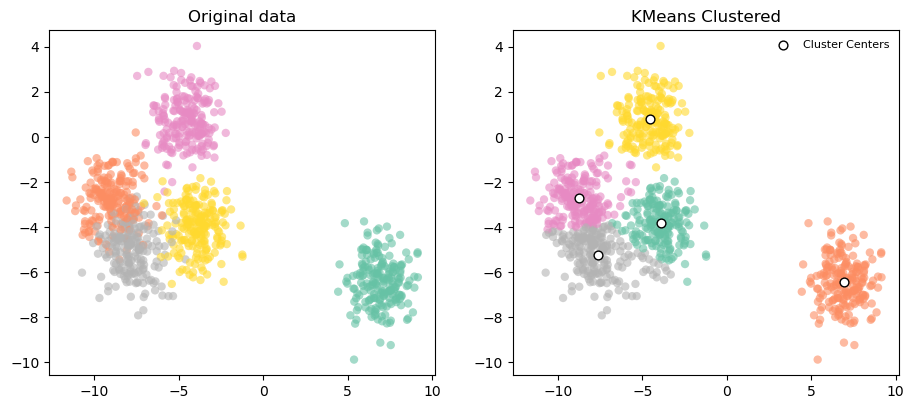

In [7]:
from sklearn.cluster import KMeans
from sklearn import preprocessing


n_clusters = 5
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
kmeans = clf.fit(scaler.fit_transform(data[:,0:2]))

centers = clf.cluster_centers_
centers_orig = scaler.inverse_transform(centers)

labels = kmeans.predict(scaler.fit_transform(data[:,0:2]))



fig = plt.figure(3, figsize=(10, 5))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.2)


ax1 = fig.add_subplot(121)
sub1 = ax1.scatter(data[:,0], data[:,1], c=data[:,2], cmap=cmap, alpha=0.6,
            norm=mpl.colors.BoundaryNorm(np.arange(-0.5,5.5,1), cmap.N), edgecolor='None')
ax1.set_title("Original data")


ax2 = fig.add_subplot(122)
sub2 = ax2.scatter(data[:,0], data[:,1], c=labels, alpha=0.6, cmap=cmap,
                  norm=mpl.colors.BoundaryNorm(np.arange(-0.5,5.5,1), cmap.N), edgecolor='None')
ax2.scatter(centers_orig[:, 0], centers_orig[:, 1],
           s=40, c='w', edgecolors='k', label='Cluster Centers')
ax2.set_title("KMeans Clustered")
plt.legend(frameon=False, fontsize=8)
plt.show()